# Investigating the impact of moderator interventions

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from matplotlib.patches import Patch

import tasks.stats
import tasks.postprocessing
import tasks.graphs

In [2]:
sns.set(
    style="whitegrid",
    font_scale=1.5,
    font="Times New Roman",
    context="paper",
    palette="colorblind",
)

In [3]:
from tasks.constants import *


TOXICITY_TICKS = np.arange(1, 6, 1)
YTICKS_LIST = [TOXICITY_TICKS, TOXICITY_TICKS]
VMIN_TOXICITY = -1
VMAX_TOXICITY = 1

## Preprocessing

In [31]:
full_df = tasks.postprocessing.get_main_dataset()
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57475 entries, 0 to 57474
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   conv_id           57475 non-null  object
 1   message_id        57475 non-null  object
 2   message_order     57475 non-null  int64 
 3   conv_variant      57475 non-null  object
 4   model             57475 non-null  object
 5   user              57475 non-null  object
 6   user_prompt       57475 non-null  object
 7   is_moderator      57475 non-null  bool  
 8   intent            57475 non-null  object
 9   message           57475 non-null  object
 10  Toxicity          57475 non-null  int64 
 11  Argument Quality  57475 non-null  int64 
 12  not_intervened    57475 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 4.9+ MB


## When do moderators intervene?

In [38]:
import pandas as pd

# Step 1: Find conv_ids with at least one moderator comment
moderated_convs = full_df[full_df['is_moderator']].conv_id.unique()

# Step 2: Filter out messages with conv_variant == "No Moderator"
filtered_df = full_df[(full_df['conv_id'].isin(moderated_convs)) & (full_df['conv_variant'] != "No Moderator")]

# Step 3: Remove duplicate messages by message_id
filtered_df = filtered_df.drop_duplicates(subset='message_id')

# Step 4: Calculate intervention_pct per conv_id
# Here, I assume 'intervention_pct' is the percentage of messages by moderators in the conversation
# You can adjust this if you want a different definition

# Count total messages per conversation
total_msgs = filtered_df.groupby('conv_id').size()

# Count moderator messages per conversation
mod_msgs = filtered_df[filtered_df['is_moderator']].groupby('conv_id').size()

# Compute intervention percentage
intervention_pct = (mod_msgs / total_msgs).fillna(0) *2* 100

# Get conv_variant per conv_id (assuming it is unique per conv)
conv_variants = filtered_df.groupby('conv_id')['conv_variant'].first()

# Create intervention_df
intervention_df = pd.DataFrame({
    'conv_id': intervention_pct.index,
    'conv_variant': conv_variants,
    'intervention_pct': intervention_pct.values
}).reset_index(drop=True)

print(intervention_df.info())
print(intervention_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   conv_id           118 non-null    object 
 1   conv_variant      118 non-null    object 
 2   intervention_pct  118 non-null    float64
dtypes: float64(1), object(2)
memory usage: 2.9+ KB
None
                                conv_id     conv_variant  intervention_pct
0  01336d04-f98a-46ec-8b1b-1eabd44f369f  No Instructions         96.551724
1  028f869d-cf12-444a-aefc-62f8b6294acd        Mod. Game         23.529412
2  04a24daf-ae9b-48bf-b7c2-c5dcd9252c24        Reg. Room         96.551724
3  0594f5fe-3bef-4642-8bb7-9ac356f44acb    Constr. Comms         96.296296
4  095f8e2c-4c6b-45d3-983b-c0a836cd1d4e        Mod. Game         96.551724


In [39]:
strategies = intervention_df.conv_variant.unique()
colorblind_palette = sns.color_palette("colorblind", n_colors=len(strategies))
palette_dict = {strategy: color for strategy, color in zip(strategies, colorblind_palette)}
hatch_dict = {strategy: hatch for strategy, hatch in zip(strategies, tasks.constants.HATCHES)}


/tmp/ipykernel_21193/732548229.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = intervention_df.groupby(['intervention_bin', 'conv_variant']).size().unstack(fill_value=0)


Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intervention_count.png


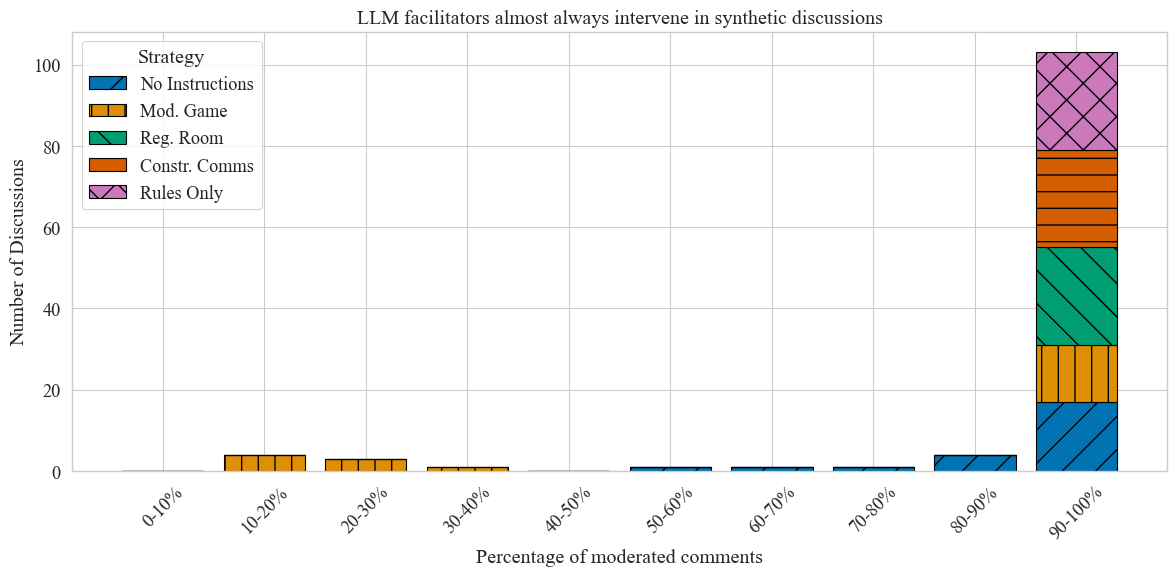

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming your DataFrame is df

# Define bins (0-10%, 10-20%, ..., 90-100%)
bins = np.arange(0, 110, 10)

# Create bins column
intervention_df['intervention_bin'] = pd.cut(intervention_df['intervention_pct'], bins=bins, right=False, include_lowest=True)

# Unique variants
variants = intervention_df['conv_variant'].unique()

# Colors and hatches for variants
colors = sns.color_palette("colorblind", 8).as_hex()
hatches = tasks.constants.HATCHES

# Group and count: rows = bins, columns = variants
grouped = intervention_df.groupby(['intervention_bin', 'conv_variant']).size().unstack(fill_value=0)
grouped = grouped.reindex(index=pd.IntervalIndex.from_breaks(bins, closed='left'), fill_value=0)

fig, ax = plt.subplots(figsize=(12,6))

x = np.arange(len(grouped))
bottom = np.zeros(len(grouped))

for i, variant in enumerate(variants):
    counts = grouped[variant].values
    bars = ax.bar(
        x,
        counts,
        bottom=bottom,
        label=variant,
        color=colors[i % len(colors)],
        edgecolor='black',
        hatch=hatches[i % len(hatches)],
    )
    bottom += counts  # stack bars on top

ax.set_xticks(x)
ax.set_xticklabels([f'{int(interval.left)}-{int(interval.right)}%' for interval in grouped.index], rotation=45)
ax.set_xlabel('Percentage of moderated comments')
ax.set_ylabel('Number of Discussions')
ax.set_title('LLM facilitators almost always intervene in synthetic discussions')
ax.legend(title='Strategy')
plt.tight_layout()
tasks.graphs.save_plot(GRAPH_OUTPUT_DIR / "intervention_count.png")
plt.show()

## Statistical Analysis

In [8]:
analysis_df = full_df.loc[
    (full_df.intent != "Moderator") & (full_df.model != "hardcoded")
]

### Moderation Strategy

#### Toxicity

In [9]:
tasks.stats.mean_comp_test(
    df=analysis_df, feature_col="conv_variant", score_col="Toxicity"
)

8.88378208253797e-199

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/toxicity_stats.png


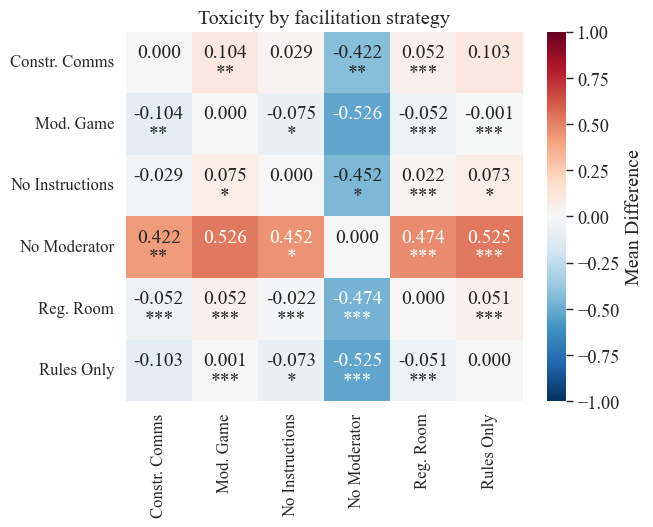

In [10]:
tasks.graphs.posthoc_heatmap(
    analysis_df,
    val_col="Toxicity",
    group_col="conv_variant",
    vmin=VMIN_TOXICITY,
    vmax=VMAX_TOXICITY,
)

tasks.graphs.save_plot(GRAPH_OUTPUT_DIR / "toxicity_stats.png")
plt.show()

#### Argument Quality

In [11]:
tasks.stats.mean_comp_test(
    df=analysis_df, feature_col="conv_variant", score_col="Argument Quality"
)

4.79135280857012e-46

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/argumentq_stats.png


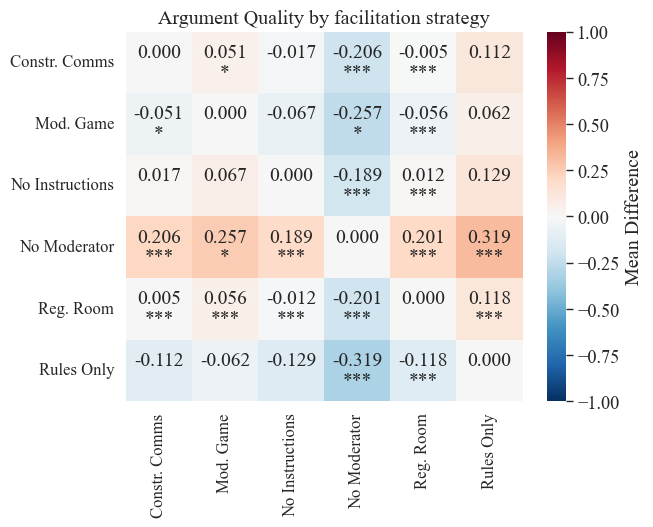

In [12]:
tasks.graphs.posthoc_heatmap(
    analysis_df,
    val_col="Argument Quality",
    group_col="conv_variant",
    vmin=VMIN_TOXICITY,
    vmax=VMAX_TOXICITY,
)

tasks.graphs.save_plot(GRAPH_OUTPUT_DIR / "argumentq_stats.png")
plt.show()